# <font color='#28B463'>DECISION TREES

<br>

## <font color='#28B463'>Introduction

<br>
Decision tree learning is a method for approximating discrete-valued target functions, in which the learned function is represented by a decision tree or, alternatively, as sets of if-then rules to improve human readability.

<br>
Decision tree learning is robust to noisy data and capable of learning disjunctive expressions; it's one of the most popular and practical algorithms for inductive inference and have been successfully applied to a broad range of tasks.

<br>
Decision trees classify instances by sorting them down the tree from the root to the leaf nodes, which provide the classification of the instance : each node in the tree specifies a test of some attribute of the instance, and each branch descending from that node corresponds to one of the possible values for this attribute. 

<br>
An instance is classified by starting at the root node of the tree, testing the attribute specified by this node, then moving down the tree branch corresponding to the value of the attribute in the given example; this process is then repeated for the subtree rooted at the new node.

<br>
The decision tree in the picture below (from <a href="http://www.cs.ubbcluj.ro/~gabis/ml/ml-books/McGrawHill%20-%20Machine%20Learning%20-Tom%20Mitchell.pdf">Tom Mitchell's Machine Learning</a>) classifies saturday mornings according to whether they are suitable for playing tennis.


<a id='decision_trees_mitchell_outlook'>
    <img src="images/decision_trees_mitchell_outlook.jpg" alt="outlook" width="60%" height="60%">
</a>

## <font color='#28B463'>Decision Tree Types

<br>
Decision trees are of two main types :

<br>
<ul style="list-style-type:square">
    <li>
        <b>classification trees</b> : the target variable can take a discrete set of values; in these tree structures, leaves
        represent class labels and branches represent conjunctions of features that lead to those class labels
    </li>
    <br>
    <li>
        <b>regression trees</b> : the target variable can take continuous values (usually real numbers) 
    </li>
</ul>

<br>
The term <b>CART (Classification And Regression Tree)</b> is an umbrella term used to refer to both of the above tree structures; classification trees and regression trees have some similarities but also some differences, such as the procedure used to determine where to split.

## <font color='#28B463'>Appropriate Problems

<br>
Although a variety of decision tree learning methods have been developed (with somewhat differing capabilities and requirements), decision trees are generally best suited to problems with the following characteristics :

<br>
<ul style="list-style-type:square">
    <li>
        <b>instances are represented by attribute-value pairs</b> : instances are described by a fixed set of attributes (e.g.
        Temperature) and their values (e.g., Hot). The easiest situation for decision tree learning is when each attribute takes
        on a small number of disjoint possible values (e.g. Hot, Mild, Cold); however, <b>extensions to the basic algorithm
        allow handling real-valued attributes as well</b>
    </li>
    <br>
    <li>
        <b>the target variable has discrete output values</b> : the decision tree in the picture above, for example, assigns a
        boolean classification to each instance; decision tree methods easily extend to learning functions with more than two
        possible output values. <b>A more substantial extension allows learning target functions with real-valued outputs</b>,
        though the application of decision trees in this setting is less common
    </li>
    <br>
    <li>
        <b>disjunctive descriptions may be required</b> : decision trees naturally represent disjunctive expressions
    </li>
    <br>
    <li>
        <b>the training data may contain errors</b> : decision tree learning methods are robust to errors, both errors in
        classifications of the training examples and errors in the attribute values that describe these examples
    </li>
    <br>
    <li>
        <b>the training data may contain missing attribute values</b> : decision tree methods can be used even when some
        training examples have unknown values
    </li>
</ul>

In [1]:
# SETUP : importing

import numpy as np
import math
import pandas as pd

from sklearn.datasets import load_boston

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

import sklearn.linear_model as lm
import sklearn.tree as tree
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import sklearn.metrics as mtr
from scipy import stats
from statsmodels.stats import diagnostic

import utilcompute as uc
import utilplot as up
import preprocessing as pre
import error_metrics as em
import regularized_regression as rr

from pprint import pprint


C:\Users\danis_p50\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# SETUP : reading in the datasets

data = np.column_stack( (load_boston().data, load_boston().target) )
df = pd.DataFrame(data)
df.columns = [
    'CRIM',    # per capita crime rate by town
    'ZN',      # proportion of residential land zoned for lots over 25,000 sq.ft.
    'INDUS',   # proportion of non-retail business acres per town
    'CHAS',    # Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    'NOX',     # nitric oxides concentration (parts per 10 million)
    'RM',      # average number of rooms per dwelling
    'AGE',     # proportion of owner-occupied units built prior to 1940
    'DIS',     # weighted distances to five Boston employment centres
    'RAD',     # index of accessibility to radial highways
    'TAX',     # full-value property-tax rate per $10,000
    'PTRATIO', # pupil-teacher ratio by town
    'B',       # 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    'LSTAT',   # % lower status of the population
    'MEDV'     # median value of owner-occupied homes in $1000's
]


In [3]:
# SETUP : printing aggregated info

#s = uc.summary(df)
#print(s)

In [4]:
target = 'MEDV'

if (isinstance(target, list)):
    features = [c for c in df.columns.values.tolist() if (c not in target)]
else:
    features = [c for c in df.columns.values.tolist() if (c != target)]

#print('features : ', features)
#print('target   : ', target)

In [5]:
#fig, axs = plt.subplots(nrows = len(features), ncols = 1, figsize=(20, 4 * len(features)))    

#for (f_index, f) in enumerate(features) :
#    ax = axs[f_index]
#    subset = df[f]        
#    sns.distplot(a= subset, ax = ax, label = f)   
#    ax.axvline(x = subset.mean(), linestyle='--')
#    ax.legend(loc='best') 

#plt.tight_layout()
#plt.show()

In [6]:
# SHUFFLING 

seed = 10
np.random.seed(seed)

df = df.reindex(np.random.permutation(df.index))


In [7]:
# SETUP : data split

train_perc = 0.8
delimiter = int(len(df) * train_perc)

df_train = pd.DataFrame( df[:delimiter] ) # train + validation
df_test = pd.DataFrame( df[delimiter:] )  # test


In [8]:
# DATA PREPROCESSING (TRAIN + VALIDATION) : features transformation

excluded_features = ['CHAS']
included_features = [f for f in features if (f not in excluded_features)]

df_cnt = pre.center(df = df_train, included = included_features, excluded = uc.concatenate(excluded_features,target))
df_std = pre.standardize(df = df_train, included = included_features, excluded = uc.concatenate(excluded_features,target))


In [9]:
# DATA PREPROCESSING (TEST) : features transformation

df_cnt_test = pre.center(df = df_test, included = included_features, excluded = uc.concatenate(excluded_features,target))
df_std_test = pre.standardize(df = df_test, included = included_features, excluded = uc.concatenate(excluded_features,target))


In [10]:
def compute_kfold_stats(df, features, target, module, model_name, model_args, note, task, debug = False):
    
    return_conditions = (
        (df.empty) or
        (not features) or
        (not target) or
        ( isinstance(target, list) and len(target) > 1) or
        (not module) or
        (not model_name) or
        (not note) or
        (not task) 
    )
    if (return_conditions):
        return
    
    if (isinstance(target, list)):
        target = target[0]
    
    n_splits = 10
    kf = KFold(n_splits = n_splits, shuffle = False, random_state = None)    
      
    columns = [
        'model_name', 'note', 'iteration', 
        'feature_importances', 
        'residuals', 'res_normality', 'res_homoscedasticity'
        # error metrics defined dynamically
    ]
    
    results_list = []    
    
    for k, (train_positions, test_positions) in enumerate(kf.split(X = df[features], y = df[target])) :
        
        fold_train = df.iloc[train_positions]   
        fold_test = df.iloc[test_positions]     
        
        if (debug and k == 0):
            print()
            print('iteration {0}   |   len(fold_train) : {1}   |   len(fold_test) : {2}   |   test_positions : [{3} - {4}]'
                  .format(k, len(fold_train), len(fold_test), test_positions[0], test_positions[-1]))   
             
        model_class_ = getattr(module, model_name)
        if (model_args):
            model = model_class_(**model_args)
        else:
            model = model_class_()      
        
        model.fit(fold_train[features], fold_train[target])        
        
        y_pred_train = model.predict(fold_train[features])
        y_pred_test = model.predict(fold_test[features])
        
        if (debug):
            if (k == 0):
                print()
                print('fold_train[target] | type : {0} | shape : {1}'.format(type(fold_train[target]), fold_train[target].shape))
                print('y_pred_train       | type : {0} | shape : {1}'.format(type(y_pred_train), y_pred_train.shape))
                print()
                print('fold_test[target]  | type : {0} | shape : {1}'.format(type(fold_test[target]), fold_test[target].shape))
                print('y_pred_test        | type : {0} | shape : {1}'.format(type(y_pred_test), y_pred_test.shape))
        
        residuals_train = (fold_train[target] - y_pred_train)
        residuals_test = (fold_test[target] - y_pred_test)
        
        if (debug and k == 0):
            print()
            print('residuals_train | type : {0} | shape : {1}'.format(type(residuals_train), residuals_train.shape))
            print('residuals_test  | type : {0} | shape : {1}'.format(type(residuals_test), residuals_test.shape))    
        
        res_normality = stats.shapiro(residuals_test)[0]
        res_homoscedasticity = diagnostic.het_breuschpagan(resid = residuals_test, exog_het = fold_test[features])[3]

        if (task == 'regression'):
            err_metrics_train = em.compute_regression_metrics(y = fold_train[target], y_pred = y_pred_train)            
            err_metrics_test = em.compute_regression_metrics(y = fold_test[target], y_pred = y_pred_test)
        elif (task == 'classification'):
            err_metrics_train = em.compute_classification_metrics(y = fold_train[target], y_pred = y_pred_train, labels = None)
            err_metrics_test = em.compute_classification_metrics(y = fold_test[target], y_pred = y_pred_test, labels = None)
            
        values_dict = {
            'model_name'    : model_name,
            'note'                 : note,
            'iteration'            : k + 1,       
            
            'feature_importances'  : model.feature_importances_,
            
            'residuals'            : residuals_test,
            'res_normality'        : res_normality,
            'res_homoscedasticity' : res_homoscedasticity
        }
        
        # useful for plotting the coefficients across some other discriminant 
        
        for (f_index, f) in enumerate(features):
            values_dict[f] = model.feature_importances_[f_index]
            
        for (f_index, f) in enumerate(features):
            values_dict[f] = model.feature_importances_[f_index]
        
        for (key, value) in err_metrics_test.items():
            values_dict[key] = value
            
        if (debug and k == 0):
            print()
            print('iteration          : {0}'.format(values_dict['iteration']))
            print('error metrics      : {0}'.format(err_metrics_test))
                            
        results_list.append(values_dict)        
                
    results_df = pd.DataFrame.from_dict(data = results_list, orient = 'columns')
    
    ordered_columns = uc.concatenate(columns, [c for c in results_df.columns.values.tolist() if (c not in columns)])
    results_df = results_df[ordered_columns]

    #results_df = results_df.astype(dtype = 'float')
        
    return results_df

## <font color='#28B463'>ID3 Algorithm

<br>
Most algorithms that have been developed for learning decision trees are variations on a <b>core algorithm, introduced by Ross Quinlan in 1986 and called ID3</b>. The ID3 algorithm begins with the original set $ \ S \ $ as the root node; on each iteration of the algorithm : 

<br>
<ol type="i">
    <li>
        every unused attribute is evaluated using a statistical test to determine how well it alone classifies the training
        examples
    </li>
    <br>
    <li>
        the best attribute is selected and used as the test at the root node of the tree
    </li>
    <br>
    <li>
        the set $ \ S \ $ is then split by the selected attribute to produce subsets of the data, each of which will
        constitute a descendant of the parent node
    </li>
    <br>
    <li>
        <b>the entire process continues recursively on each of the descendant nodes (or subsets)</b>, determining the best
        attribute to use at that point in the tree <b>considering only attributes never selected before</b>
    </li>
</ol>

<br> <br>
Recursion on a subset (or internal node) may stop in one of these cases :

<br>
<ul style="list-style-type:square">
    <li>
        every element in the subset belongs to the same class; in this case the node is turned into a leaf and labelled with the
        class of the examples
    </li>
    <br>
    <li>
        the examples still do not belong to the same class but there are no more attributes to be selected, in this case the
        node is turned into a leaf and labelled with the most common class of the examples in the subset
    </li>
    <br>
    <li>
        there are no examples in the subset, this happens when no example in the parent set was found to be matching a specific
        value of the selected attribute; in this case a leaf is created, and labelled with the most common class of the examples
        in the parent set
    </li>
</ul>


## <font color='#28B463'>Metrics

<br>
The central choice in the ID3 algorithm is selecting which attribute to test at each node in the tree; we would like to select the attribute that is most useful for classifying examples, but what is a good quantitative measure of the worth of an attribute?


### <font color='#28B463'>Entropy

<br>
In Information Theory, (information) <b>entropy is defined as the average amount of information produced by a stochastic source of data</b> or, equivalently, as a measure of unpredictability of the state of a system.

<br>
<b><font color='#28B463'>Example</font></b> : to get an intuitive understanding of these terms, we consider the example of a <b>political poll</b>. Usually, such polls happen because the outcome of the poll is not already known. In other words, the outcome of the poll is relatively unpredictable, and actually performing the poll and learning the results gives some new information; these are just different ways of saying that the a priori entropy of the poll results is large. Now, consider the case that the same poll is performed a second time shortly after the first poll. Since the result of the first poll is already known, the outcome of the second poll can be predicted well and the results should not contain much new information; in this case the a priori entropy of the second poll result is small relative to that of the first.

<br>
<b><font color='#28B463'>Example</font></b> : now we consider the example of a <b>coin toss</b>; assuming the probability of heads is the same as the probability of tails, then the entropy of the coin toss is as high as it could be. This is because there is no way to predict the outcome of the coin toss ahead of time: if we have to choose, the best we can do is predict that the coin will come up heads, and this prediction will be correct with probability 1/2. Such a coin toss has one bit of entropy since there are two possible outcomes that occur with equal probability, and learning the actual outcome contains one bit of information. In contrast, a coin toss using a coin that has two heads and no tails has zero entropy since the coin will always come up heads, and the outcome can be predicted perfectly.

<br>
Claude Shannon defined the entropy $ \ \mathrm{H} \ $ of a discrete random variable $ \ X \ $ with probability mass function $ \ P(X) \ $ and information content $ \ \mathrm{I}(X) \ $ as below, where the measure of information entropy associated with each possible data value is the negative logarithm of the probability mass function for the value :

<br>
$
    \quad
    \begin{align}
        \mathrm{H}(X) 
        &= 
        \newline
        &= \mathbf{E} \left[ \ \mathrm{I}(X) \ \right] = \mathbf{E} \left[ \ - \ln \mathrm{P}(X) \ \right]
        \newline
        &= 
                \sum _{i=1}^{n} {\mathrm{P}(x_{i}) \ \mathrm{I}(x_{i})} 
            = - \sum _{i=1}^{n} {\mathrm{P}(x_{i}) \ \log _{b} \ \mathrm {P}(x_{i})}
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            & [\textbf{E1}] 
    \end{align}
$

<br>
In the case of $ \ \mathrm{P}(x_{i}) = 0 \ $ for some $i$, the value of the corresponding summand 0 logb(0) is taken to be 0, which is consistent with the limit:

<br>
$ \quad \lim _{p\to 0+} p\log(p) = 0 $

<br>
Common values for base of the logarithm are 2, Euler's number $ \ e \ $, and 10; the corresponding units of entropy are the binary digits (bits), natural digits (nats), and decimal digits (decits).

<br>
<b><font color='#28B463'>Diversity Index</font></b>

<br>
It has been shown that Shannon Entropy can be used as a diversity index : <b>a quantitative measure that reflects how many different types there are in a dataset and simultaneously takes into account how evenly the basic entities are distributed among those types</b>. In ecology, the types would correspond to the species, the dataset to the community, and the basic entities to individuals.

<b><font color='#28B463'>Example</font></b> : to illustrate, suppose $ \ S \ $ is a collection of 14 examples of some boolean
concept (positive/negative, red/blue), including 9 red and 5 blue examples; then the entropy of the collection $ \ S \ $ relative to this boolean classification is :

<br>
$
    \quad
    \mathrm{H}(S) \quad = \quad - \ \tfrac{9}{14} \log _{2}\tfrac{9}{14} - \tfrac{5}{14} \log _{2}\tfrac{5}{14} 
    \quad = \quad 0.94
$

<br>
Notice that the entropy is 0 if all members of $ \ S \ $ belong to the same class, and the entropy is 1 when the collection contains an equal number of positive and negative examples.

### <font color='#28B463'>Information Gain

<br>
Given entropy as a measure of the impurity in a collection of training examples, we can now define a measure of the effectiveness of an attribute in classifying the training data. The measure we will use, called <b>information gain, is simply the expected reduction in entropy caused by partitioning the examples according to this attribute</b>.

<br>
More precisely, the information gain $ \ Gain(S, A) \ $ of an attribute $ \ A \ $ relative to a collection of examples $ \ S \ $ is defined as :

<br>
$
    \quad
    Gain(S, A) \quad = \quad
        \mathrm{H}(S) 
        - \sum _{\ v \ \in \ values(A)} \dfrac{\mid \ S_v \ \mid}{\mid \ S \ \mid} \ \mathrm{H}(S_v)
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad
        [\textbf{E2}] 
$

where $ values(A) $ is the set of all possible values for attribute $ \ A \ $, and $ \ S_v \ $ is the subset of $ \ S \ $ for which attribute $ \ A \ $ has value $ \ v \ $ ($ \ S_v = \{s \in S \mid A(s) = v\} \ $).

<br> <br>
The first term in <b>E2</b> is just the entropy of the original collection, and the second term is the sum of the entropies of each subset weighted by the fraction of examples that belong to the subset. Equivalently, <b>the second term represents the expected value of the entropy after the original collection $ \ S \ $ is partitioned using attribute $ \ A \ $ </b>.

<br>
In other words, the information gain is the information provided about the target function value, given the value of some
other attribute $ \ A \ $. The value of $ \ Gain(S, A) \ $ is the number of bits saved when encoding the target value of an arbitrary member of the collection $ \ S \ $, by knowing the value of attribute $ \ A \ $.

<br>
<b><font color='#28B463'>Example</font></b> : suppose $ \ S \ $ is a collection of days described by attributes including Wind, which can have the values Weak or Strong. As before, assume the collection is composed of 14 examples, 9 labelled as positive and 5 as negative. Now suppose that, of this training set, 6 of the positive and 2 of the negative examples have Wind = Weak, and the remainder have Wind = Strong. The information gain due to sorting the original collection by the attribute Wind may then be calculated as :

<br>
$
    \quad
    \begin{align}
        Gain(S, Wind) 
        &=
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad 
            & \text{by } \textbf{E2} 
        \newline
        &=
            \mathrm{H}(S) 
            \ - \ \sum _{\ v \ \in \ Wind} \dfrac{\mid \ S_v \ \mid}{\mid \ S \ \mid} \ \mathrm{H}(S_v)
        \newline
        &= 
            0.94 \ - \ \left[ \ \tfrac{8}{14} \mathrm{H}(S_{weak})  - \tfrac{6}{14} \mathrm{H}(S_{strong})  \ \right]
            & \text{by } \textbf{E1} 
        \newline
        &= 
            0.94 
            \ - \ \tfrac{8}{14} \left[ - \ \tfrac{6}{8} \log _{2}\tfrac{6}{8} - \tfrac{2}{8} \log _{2}\tfrac{2}{8} \ \right]
            \ - \ \tfrac{6}{14} \left[ - \ \tfrac{3}{6} \log _{2}\tfrac{3}{6} - \tfrac{3}{6} \log _{2}\tfrac{3}{6} \ \right]
        \newline
        &= 0.048
    \end{align}
$

<br>
<b><font color='#28B463'>Drawbacks</font></b>

Although information gain is usually a good measure for deciding the relevance of an attribute, it is not perfect. <b>A notable problem occurs when information gain is applied to attributes that can take on a large number of distinct values</b>. For example, suppose that we are building a decision tree for some data describing the customers of a business. Information gain is often used to decide which of the attributes are the most relevant, so they can be tested near the root of the tree. One of the input attributes might be the customer's credit card number. This attribute has a high mutual information, because it uniquely identifies each customer, but we do not want to include it in the decision tree: deciding how to treat a customer based on their credit card number is unlikely to generalize to customers we haven't seen before.

<br>
<b>Information gain ratio is sometimes used instead; this biases the decision tree against considering attributes with a large number of distinct values</b>. However, <b>attributes with very low information values then appeared to receive an unfair advantage</b>.


## <font color='#28B463'>ID3 Properties and Limitations 

<br>
As with other inductive learning methods, ID3 can be characterized as searching a space of hypotheses for one that fits the training examples; the hypothesis space searched by ID3 is the set of possible decision trees. ID3 performs a top-down, simple-to-complex search through this hypothesis space, beginning with the empty tree, then considering progressively more elaborate hypotheses in search of a decision tree that correctly classifies the training data.

<br>
By viewing ID3 in terms of its search space and search strategy, we can get some insight into its capabilities and limitations.


<br>
<b><font color='#28B463'>Completeness</font></b>

ID3 hypothesis space of all decision trees is a complete space of finite discrete-valued functions, relative to the available attributes. Because every finite discrete-valued function can be represented by some decision tree, ID3 avoids one of the major risks of methods that search incomplete hypothesis spaces (such as methods that consider only conjunctive hypotheses): that the
hypothesis space might not contain the target function.

<br>
<b><font color='#28B463'>Singularity</font></b>

ID3 maintains only a single current hypothesis as it searches through the space of decision trees. By determining only a single hypothesis, ID3 loses the capabilities that follow from explicitly representing all consistent hypotheses. For example, it does not have the ability to determine how many alternative decision trees are consistent with the available training data.

<br>
<b><font color='#28B463'>BackTracking</font></b>

ID3 in its pure form performs no backtracking in its search. Once it selects an attribute to test at a particular level in the tree, it never backtracks to reconsider this choice. Therefore, it is susceptible to the usual risks of hill-climbing search without backtracking : converging to locally optimal solutions that are not globally optimal. In the case of ID3, a locally optimal solution corresponds to the decision tree it selects along the single search path it explores. However, this locally optimal solution may be less desirable than trees that would have been encountered along a different branch of the search.

<br>
<b><font color='#28B463'>Robustness to noise</font></b>

ID3 uses all training examples at each step in the search to make statistically based decisions regarding how to refine its current hypothesis. One advantage of using statistical properties of all the examples (e.g. information gain) is that the resulting search is much less sensitive to errors in individual training examples. ID3 can be easily extended to handle noisy training data by modifying its termination criterion to accept hypotheses that imperfectly fit the training data.

<br>
<b><font color='#28B463'>Discretization</font></b>

ID3 is harder to use on continuous data : if the values of any given attribute is continuous, then there are many more places to split the data on this attribute, and searching for the best value to split by can be time consuming.

<br>
<b><font color='#28B463'>Overfitting</font></b>

ID3 can overfit to the training data; to avoid overfitting, smaller decision trees should be preferred over larger ones. This algorithm usually produces small trees, but it does not always produce the smallest possible tree.


## <font color='#28B463'>Inductive Bias in Decision Tree Learning

<br>
What is the policy by which ID3 generalizes from observed training examples to classify unseen instances? In other words, what is its inductive bias? Recall that <b>inductive bias is the set of assumptions that, together with the training data, deductively justify the classifications assigned by the learner to future instances</b>.

<br>
Given a collection of training examples, there are typically many decision trees consistent with these examples. Describing the inductive bias of ID3 therefore consists of describing the basis by which it chooses one of these consistent hypotheses over the others. Which of these decision trees does ID3 choose?

<br>
It chooses the first acceptable tree it encounters in its simple-to-complex, hill-climbing search through the space of possible trees. Because of the subtle interaction between the attribute selection heuristic used by ID3 (information gain) and the particular training examples it encounters, it is difficult to characterize precisely the inductive bias exhibited by ID3. However, we can
approximately characterize its bias by saying that <b>ID3 search strategy</b>:

<br>
<ul style="list-style-type:square">
    <li>
         <b>selects in favor of shorter trees over longer ones</b>
    </li>
    <br>
    <li>
        <b>selects in favor of trees that place high information gain attributes close to the root over those that do not</b>
    </li>
</ul>


## <font color='#28B463'>Issues in Decision Tree Learning

<br>
Practical issues in learning decision trees include determining how deeply to grow the decision tree, handling continuous attributes, choosing an appropriate attribute selection measure, handling training data with missing attribute values, handling
attributes with differing costs, and improving computational efficiency. 

<br>
Below we discuss each of these issues and the corresponding extensions to the basic ID3 algorithm, which has been further developed to address most of these issues, with the resulting system renamed C4.5 (<a href="https://en.wikipedia.org/wiki/C4.5_algorithm">Quinlan, 1993</a>)


## <font color='#28B463'>[I1] Avoiding Overfitting the Data

<br>
The ID3 algorithm grows each branch of the tree just deeply enough to perfectly classify the training examples. While this is sometimes a reasonable strategy, in fact it can lead to difficulties when there is noise in the data, or when the number of training examples is too small to produce a representative sample of the true target function. In either of these cases, this simple algorithm can produce trees that overfit the training examples.

<br>
Given a hypothesis space $ \ H \ $, a hypothesis $ \ h \ \in \ H \ $ is said to overfit the training data if there exists some alternative hypothesis $ \ h' \ \in \ H \ $, such that $ \ h \ $ has smaller error than $ \ h' \ $ over the training examples, but the latter outperforms the former over the entire distribution of instances.


### <font color='#28B463'>Overfitting due to noise

<br>
One way overfitting can occur is when the training examples contain random errors or noise. To illustrate this, let's consider the effect of adding the following positive training example, incorrectly labeled as negative, to the original collection : 

<br>
$
    \quad \text{< Outlook = Sunny, Temperature = Hot, Humidity = Normal, Wind = Strong, PlayTennis = No>}
$

<br>
Given the original error-free data, ID3 will produce the decision tree shown in the <a href='#decision_trees_mitchell_outlook'>figure above</a>. However, the addition of this incorrect example will now cause ID3 to
construct a more complex tree; in particular, the new example will be sorted into the second leaf node from the left in the learned tree. 

<br>
Because the new example is labeled as a negative example, ID3 will search for further refinements to the tree below this node. Of course, as long as the new erroneous example differs in some arbitrary way from the other examples affiliated with this node, ID3 will succeed in finding a new decision attribute to separate out this new example from the two previous positive examples at this tree node. 

<br>
The result is that ID3 will output a decision tree $ \ h \ $ that is more complex than the original tree $ \ h' \ $. Of course the new tree will fit the collection of training examples perfectly, whereas the simpler tree will not. However, given that the new decision node is simply a consequence of fitting the noisy training example, we expect $ \ h' \ $ to outperform $ \ h \ $ over subsequent data drawn from the same instance distribution.


### <font color='#28B463'>Overfitting due to small size of terminal nodes

<br>
Overfitting can also occur when the terminal (leaf) nodes are associated with a small numbers of examples. In this case, it is quite possible for coincidental regularities to be found, in which some attribute happens to partition the examples very well, despite being unrelated to the actual target function. Whenever such coincidental regularities exist, there is a risk of overfitting.


### <font color='#28B463'>Solutions

<br>
There are several approaches to avoiding overfitting in decision tree learning which can be grouped into two classes :

<br>
<ul style="list-style-type:square">
    <li>
         approaches that <b>stop growing the tree</b> earlier, <b>before it reaches the point where it perfectly classifies the
         training data</b>
    </li>
    <br>
    <li>
        approaches that allow the tree to overfit the data, and then <b>post-prune the tree</b>
    </li>
</ul>

<br>
Although the first of these approaches might seem.more direct, the second approach of <b>post-pruning overfit trees has been found to be more successful in practice</b>. This is due to the difficulty in the first approach of estimating precisely when to stop growing the tree.


<b><font color='#28B463'>[ S1 ] Reduced-Error Pruning</font></b>

<br>
Reduced-error pruning (Quinlan, 1987) considers each of the decision nodes in the tree to be candidates for pruning. Pruning a decision node consists of <b>removing the subtree rooted at that node, making it a leaf node, and assigning it the most common classification</b> of the training examples <b>affiliated with that node</b>. 

<br>
Nodes are removed only if the resulting pruned tree performs no worse than the original over the validation set. This has the effect that <b>any leaf node added due to coincidental regularities in the training set is likely to be pruned because these
same coincidences are unlikely to occur in the validation set</b>. 

<br>
<a id='decision_trees_mitchell_reduced_error_pruning'>
    <img src="images/decision_trees_mitchell_reduced_error_pruning.jpg" alt="reduced_error_pruning" width="50%" height="50%">
</a>

<br>
When pruning begins, the tree is at its maximum size and lowest accuracy over the test set. Nodes are pruned iteratively, always choosing the node whose removal most increases the decision tree accuracy over the validation set. As pruning proceeds, the number of nodes is reduced and accuracy over the test set increases. <b>Pruning of nodes continues until further pruning is harmful (i.e. decreases accuracy of the tree over the validation set)</b>.

<b><font color='#28B463'>[ S2 ] Rule Post Pruning</font></b>

<br>
One quite successful method for finding high accuracy hypotheses is a technique we shall call <b>rule post-pruning</b>, a variant of which is implemented in C4.5 (<a href="https://en.wikipedia.org/wiki/C4.5_algorithm">Quinlan, 1993</a>). Rule post-pruning involves the following steps :

<br>
<ol type="i">
    <li>
        infer the decision tree from the training set, <b>growing the tree until the training data is fit as well as
        possible</b> and allowing overfitting to occur
    </li>
    <br>
    <li>
        <b>convert the learned tree into an equivalent set of rules</b> by creating one rule for each path from the root node to
        a leaf node
    </li>
    <br>
    <li>
        <b>prune (generalize) each rule</b> by removing any preconditions whose removal does not worsen the estimated rule
        accuracy
    </li>
    <br>
    <li>
        <b>sort the pruned rules by their estimated accuracy</b>, and consider them in this sequence when classifying subsequent
        instances
    </li>
</ol>

<br>
<a id='decision_trees_mitchell_continuous_values_2'>
    <img src="images/decision_trees_mitchell_outlook.jpg" alt="outlook" width="60%" height="60%">
</a>

<br>
To illustrate, let's consider again the decision tree in the <a href='#decision_trees_mitchell_outlook'>first figure</a>. In rule post-pruning, one rule is generated for each leaf node in the tree. Each attribute test along the path from the root to the leaf becomes a rule antecedent (or precondition) and the classification at the leaf node becomes the rule consequent (or post-condition). 

<br>
For example, the leftmost path of the tree is translated into the rule :

<br>
$
    \quad
    \begin{align}
        \text{if } \quad & \text{(Outlook = Sunny) } \land \text{ (Humidity = High)}
        \newline
        \text{then } \quad & \text{PlayTennis = No}
    \end{align}
$

<br>
Next, each such rule is pruned by removing any antecedent, or precondition, whose removal does not worsen its estimated accuracy. Given the above rule, for example, rule post-pruning would consider removing the preconditions $\text{(Outlook = Sunny)}$ and $\text{(Humidity = High)}$. It would select whichever of these pruning steps produced the greatest improvement in estimated rule accuracy, then consider pruning the second precondition as a further pruning step. No pruning step is performed if it reduces the estimated rule accuracy.

<br>
<b>Why convert the decision tree to rules before pruning</b>? There are three main advantages :

<br>
<ul style="list-style-type:square">
    <li>
        <b>converting to rules allows distinguishing among the different contexts in which a decision node is used</b>. Because
        each distinct path through the decision tree node produces a distinct rule, the pruning decision regarding that
        attribute test can be made differently for each path. In contrast, if the tree itself were pruned, the only two choices
        would be to remove the decision node completely, or to retain it in its original form
    </li>
    <br>
    <li>
        <b>converting to rules removes the distinction between attribute tests that occur near the root of the tree and those
        that occur near the leaves</b>. Thus, we avoid messy bookkeeping issues such as how to reorganize the tree if the root
        node is pruned while retaining part of the subtree below this test
    </li>
    <br>
    <li>
        <b>converting to rules improves readability</b>; rules are often easier for people to understand
    </li>
</ul>


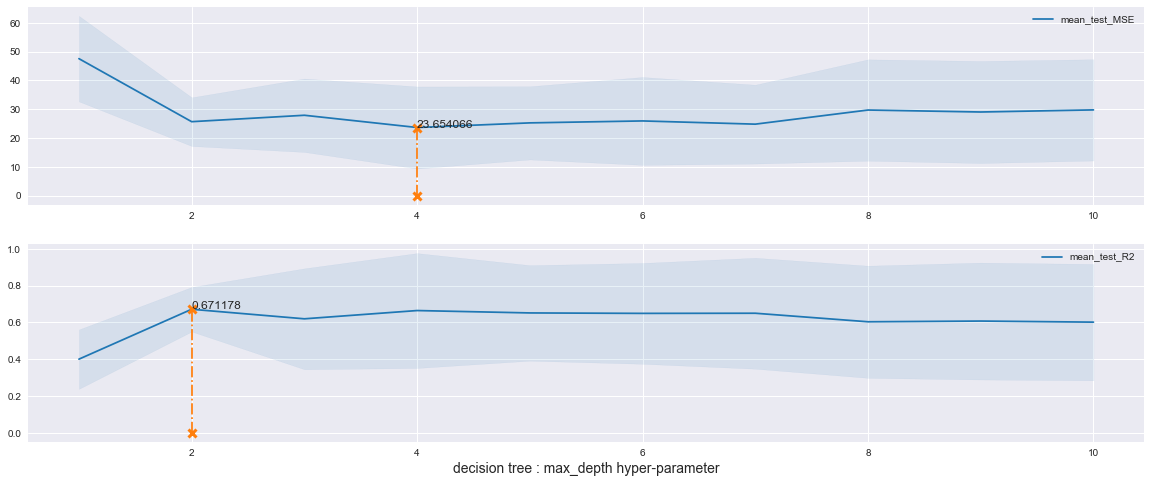

In [11]:
max_depth = np.arange(1, 10 + 1)

scoring_list = {
    'MSE' : 'neg_mean_squared_error', 
    'R2' : 'r2'}

grid = GridSearchCV(
    estimator = tree.DecisionTreeRegressor(), 
    param_grid = {'max_depth': max_depth}, 
    scoring = scoring_list,  
    refit = 'MSE',
    cv = 10
)

grid.fit(df_std[features], df_std[target])
grid_results = grid.cv_results_

rr.plot_gridsearch_cv(
    param_name = 'param_max_depth', 
    param = max_depth, 
    scoring_list = scoring_list, 
    grid_results = grid_results, 
    plot_args = {'xticks' : max_depth, 'xscale' : 'linear', 'xlabel' : 'decision tree : max_depth hyper-parameter'}
)


## <font color='#28B463'>[I2] Incorporating Continuous-Valued Attributes

<br>
The initial definition of ID3 is restricted to attributes that take on a discrete set of values. Both the target and the decision attributes (those which are tested in the decision nodes) must be discrete-valued. 


### <font color='#28B463'>Binary Discretization

<br>
The second restriction can easily be removed so that continuous-valued decision attributes can be incorporated into the learned tree. This can be accomplished by dynamically defining new discrete-valued attributes that partition the continuous attribute value into a discrete set of intervals. In particular, for a continuous-valued attribute $ \ A \ $, the algorithm can dynamically create a new boolean attribute $ \ A' \ $, that is true if $ \ A < c \ $ and false otherwise. The only question is how to select the best value for the threshold $ \ c \ $.

<b><font color='#28B463'>Example</font></b> : suppose we wish to include the continuous-valued attribute $ \ Temperature \ $ in describing the decision tree we are already familiar with (<a href='#decision_trees_mitchell_outlook_2'>figure</a>); suppose further that the training examples associated with a particular node in the decision tree have the following values for $ \ Temperature \ $ and the target attribute $ \ PlayTennis \ $ :

<br>
<a id='decision_trees_mitchell_continuous_values'>
    <img src="images/decision_trees_mitchell_continuous_values.jpg" alt="continuous_values" width="40%" height="40%">
</a>

<br>
Clearly, we would like to pick a threshold $ \ c \ $ that produces the greatest information gain. <b>By sorting the examples according to the continuous attribute $ \ A \ $, then identifying adjacent examples that differ in their target classification, we can generate a set of candidate thresholds midway between the corresponding values of $ \ A \ $. These candidate thresholds
can then be evaluated by computing the information gain associated with each</b>.

<br>
In the current example, there are two candidate thresholds, corresponding to the values of $ \ Temperature \ $ at which the value of $ \ PlayTennis \ $ changes: (48 + 60)/2 and and (80 + 90)/2. The information gain can then be computed for each of the
candidate attributes, $ \ Temperature_{ \ > 54} \ $ and $ \ Temperature_{ \ > 85} \ $, and the best can be selected.

<br>
The method described above dynamically creates a boolean attribute which can then compete with the other discrete-valued decision attributes available for growing the decision tree.


### <font color='#28B463'>Generalization

<br>
Fayyad and Irani (<a href="https://trs.jpl.nasa.gov/bitstream/handle/2014/35171/93-0738.pdf?sequence=1&isAllowed=y">Multi-Interval Discretization of Continuous-Valued Attributes for Classification Learning</a>, 1993) discuss an extension to this approach that splits the continuous attribute into multiple intervals rather than just two intervals based on a single threshold.


## <font color='#28B463'>[I3] Alternative Measures for Selecting Attributes

<br>
<b>There is a natural bias in the information gain measure that favors attributes with many values over those with few values</b> : a decision attribute with a large number of values is bound to separate the training examples into very small subsets and, because of this, it will have a very high information gain relative to the training examples (despite being a very poor predictor of the target function over unseen instances).

<br>
Such attribute would then be selected as the decision attribute for the root node of the tree and lead to a (quite
broad) tree of depth one, which perfectly classifies the training data while performing poorly on subsequent examples. One way to avoid this difficulty is to select decision attributes based on some measure other than information gain. 

<br>
One alternative measure that has been used successfully is the Gain Ratio (Quinlan 1986). <b>The gain ratio penalizes
attributes with a large number of values by incorporating a term, called split information, that is sensitive to how broadly and uniformly the attribute splits the data</b> :

<br>
$
    \quad
    \operatorname{Split Information} \ (S, A) \quad = \quad
        - \sum _{i=1}^{c} \dfrac{\mid \ S_i \ \mid}{\mid \ S \ \mid} \ \log _{2} \dfrac{\mid \ S_i \ \mid}{\mid \ S \ \mid}
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad
        [\textbf{E3}] 
$

where $ \ S_1 \ $ through $ \ S_c \ $ are the subsets resulting from partitioning the original collection by attribute $ \ A \ $. 

<br>
Split Information is actually the entropy of $ \ S \ $ with respect to the values of attribute $ \ A \ $; this is in contrast to our previous uses of entropy, in which we considered only the entropy of $ \ S \ $ with respect to the target attribute.

<br><br>
The Gain Ratio measure is defined in terms of both Information Gain and Split Information as follows :

<br>
$
    \quad
    \operatorname{Gain Ratio} \ (S, A) \quad = \quad
        \dfrac {\operatorname{Gain} \ (S, A)} {\operatorname{Split Information} \ (S, A)}
        \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \quad
        [\textbf{E4}] 
$

<br>
<b><font color='#28B463'>Limitations of Gain Ratio</font></b>

<br>
One practical issue that arises in using gain ratio in place of gain to select attributes is that the denominator can be zero or very small when $ \ S_i \simeq S \ $ for one of the subsets; this either makes the <b>gain ratio undefined or very large for
attributes that happen to have the same value for nearly all members of the original collection</b>. To avoid selecting attributes purely on this basis, we can adopt some heuristic such as first calculating the Gain of each attribute, then applying the gain ration test only considering those attributes with gain above the average (Quinlan 1986).

<br>
Further selection methods are discussed in <a href="http://www.cs.ubbcluj.ro/~gabis/ml/ml-books/McGrawHill%20-%20Machine%20Learning%20-Tom%20Mitchell.pdf">Tom Mitchell's Machine Learning</a>.

In [12]:
dectree_list = [
    { 'df' : df_train, 'module' : tree, 'model_name' : 'DecisionTreeRegressor', 
     'model_args' : {'criterion' : 'mse', 'splitter' : 'best', 'max_depth' : 4}, 'note' : 'original' },
    #{ 'df' : df_sk, ''module' : tree, 'model_name' : 'DecisionTreeRegressor', 
    # 'model_args' : {'criterion' : 'mse', 'splitter' : 'best', 'max_depth' : 4}, 'note' : 'un-skewed' },
    { 'df' : df_cnt, 'module' : tree, 'model_name' : 'DecisionTreeRegressor', 
     'model_args' : {'criterion' : 'mse', 'splitter' : 'best', 'max_depth' : 4}, 'note' : 'centered' },
    { 'df' : df_std, 'module' : tree, 'model_name' : 'DecisionTreeRegressor', 
     'model_args' : {'criterion' : 'mse', 'splitter' : 'best', 'max_depth' : 4}, 'note' : 'standardized'}    
]

results = pd.DataFrame()

for l in dectree_list:
    results_temp = compute_kfold_stats(
        df = l['df'], 
        features = features, 
        target = [target], 
        module = l['module'],
        model_name = l['model_name'], 
        model_args = l['model_args'],
        note = l['note'],
        task = 'regression',
        debug = False
    )
    results = results.append(results_temp).reset_index(drop = True)


## <font color='#28B463'>Features importance

<br>

In [13]:
discriminant_values = results['note'].unique().tolist() 

bar_height = 0.3
bar_margin = 0.1

ticks = (bar_height * np.arange(len(features)))
for (t_index, t) in enumerate(ticks):
    if (t_index > 0):
        ticks[t_index] += (bar_margin * t_index)

y_ticks_centers = ticks

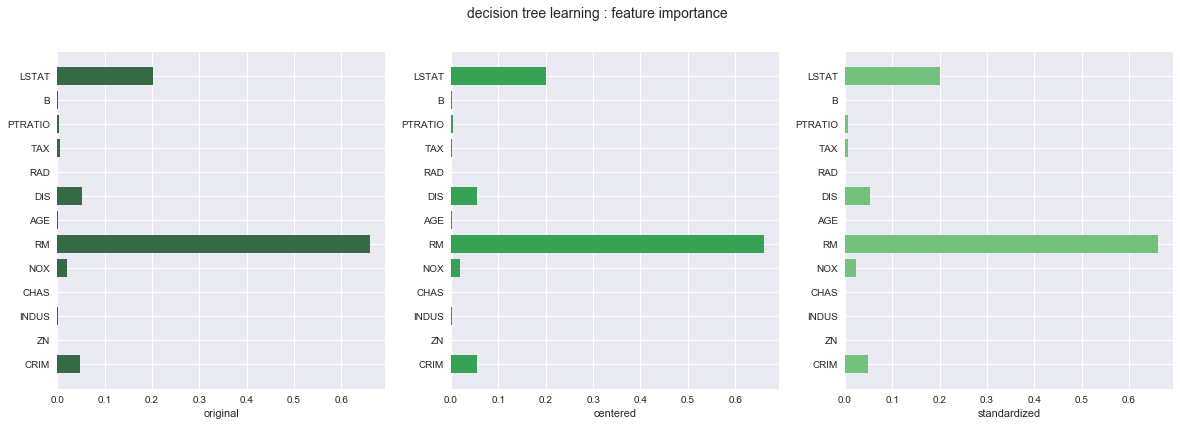

In [14]:
pal = sns.color_palette("Greens_d", len(discriminant_values))

n_rows = 1
n_cols = len(discriminant_values)

fig_width = 20
max_height_per_row = (bar_height + bar_margin) * len(features) + 1
fig_height = (max_height_per_row * n_rows) 


fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(fig_width, fig_height))            
fig.suptitle(t = 'decision tree learning' + ' : {0}'.format('feature importance'), fontsize = 14)          

p = 0
for (d_index, d) in enumerate(discriminant_values): 
    criteria = (results['note'] == d)
    subset = results[criteria]    
    ax = axs[d_index]
    ax.set_xlabel(d)
    for (f_index, f) in enumerate(features):              
        ax.barh(bottom = y_ticks_centers[f_index] , width = subset[f].mean(), height = bar_height,  
                align = 'center', label = d, color = pal[p])
        ax.set_yticks(ticks = y_ticks_centers, minor = False)
        ax.set_yticklabels(labels = features)         
    p += 1    
plt.show()


## <font color='#28B463'>Impact on the regression score

<br>

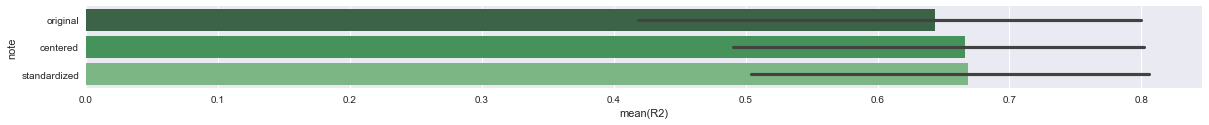

R2 mean (original)       :                             0.6433
R2 mean (centered)       :                             0.6661
R2 mean (standardized)   :                             0.6683


In [15]:
metric = 'R2'

up.plot_across_discriminant(
    df = results, 
    cols = [metric], 
    discriminant_col = 'note', 
    plot_args = {'title' : 'decision tree learning', 'skewness' : False, 'normality' : False}, 
    distplot = False,
    sem      = False, 
    adj_sem  = False,
    mean     = True
)


discriminant_values = results['note'].unique().tolist() 
template = "{0:25}:{1:>35}" 
for (d_index,d) in enumerate(discriminant_values):
    label = ('{0} mean ({1})'.format(metric, d))    
    criteria = (results['note'] == d)    
    subset = results[criteria][metric]        
    print(template.format(label, round(subset.mean(), 4)))

## <font color='#28B463'>Considerations

<br>
Decision trees provide a practical method for learning <b>discrete-valued functions</b>. The ID3 family of algorithms infers decision trees by growing them from the root downward, greedily selecting the next best attribute for each new decision branch added to the tree.

<br>
ID3 searches a <b>complete hypothesis space (i.e. the space of decision trees can represent any discrete-valued function defined over discrete-valued instances)</b>; it thereby avoids the major difficulty associated with approaches that consider only restricted sets of hypotheses : that the target function might not be present in the hypothesis space.

<br>
The <b>inductive bias implicit in ID3 includes a preference for smaller trees</b>; its search through the hypothesis space grows the tree only as large as needed in order to classify the available training examples.

<br>
Overfitting the training data is an important issue in decision tree learning; <b>post-pruning methods are therefore important to avoid overfitting in decision tree learning</b> (and other inductive inference methods that employ a preference bias).

<br>
A large variety of <b>extensions to the basic ID3 algorithm has been developed</b> by different researchers. These include methods for post-pruning trees, handling real-valued attributes, accommodating training examples with missing attribute values, incrementally refining decision trees as new training examples become available, using attribute selection measures other than
information gain, and considering costs associated with instance attributes.


## <font color='#28B463'>References

<br>
<ul style="list-style-type:square">
    <li>
        Wikipedia - Decision Tree Learning <br>
        https://en.wikipedia.org/wiki/Decision_tree_learning
    </li>
    <br>
    <li>
        Wikipedia - ID3 Algorithm <br>
        https://en.wikipedia.org/wiki/ID3_algorithm
    </li>
    <br>
    <li>
        Wikipedia - Entropy <br>
        https://en.wikipedia.org/wiki/Entropy_(information_theory)
    </li>
    <br>
    <li>
        Wikipedia - Diversity Index <br>
        https://en.wikipedia.org/wiki/Diversity_index
    </li>
    <br>
    <li>
        Wikipedia - Information Gain in Decision Trees <br>
        https://en.wikipedia.org/wiki/Information_gain_in_decision_trees
    </li>
    <br>
    <li>
        Fayyad and Irani - Multi-Interval Discretization of Continuous-Valued Attributes for Classification Learning <br>
        https://trs.jpl.nasa.gov/bitstream/handle/2014/35171/93-0738.pdf?sequence=1&isAllowed=y
    </li>
    <br>
    <li>
        Tom Mitchell - Machine Learning <br>
        http://www.cs.ubbcluj.ro/~gabis/ml/ml-books/McGrawHill%20-%20Machine%20Learning%20-Tom%20Mitchell.pdf
    </li>
</ul>
